In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn import linear_model

In [66]:
df_music = pd.read_csv('../music_data/billboard_top_100_1960_1969.csv')

In [67]:
df_music.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount
count,1000.000000,1000,1000,1000.000000,1.000000e+03
unique,NaN,551,987,NaN,NaN
top,NaN,The Beatles,Groovin',NaN,NaN
freq,NaN,23,2,NaN,NaN
mean,50.547000,NaN,NaN,1964.501000,7.899716e+06
std,28.922799,NaN,NaN,2.875111,1.992259e+07
min,1.000000,NaN,NaN,1960.000000,1.554000e+03
25%,25.750000,NaN,NaN,1962.000000,2.437070e+05
50%,50.500000,NaN,NaN,1964.500000,8.641245e+05
75%,76.000000,NaN,NaN,1967.000000,4.963935e+06


# 1 Visualization

## 1.1 Heat Map: Correlation

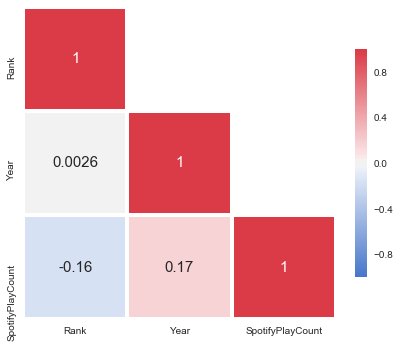

In [68]:
sns.set(style="white")
corr = df_music.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})

## 1.2 Histogram: Play Count (Original)

In [69]:
df_playCount = df_music.SpotifyPlayCount

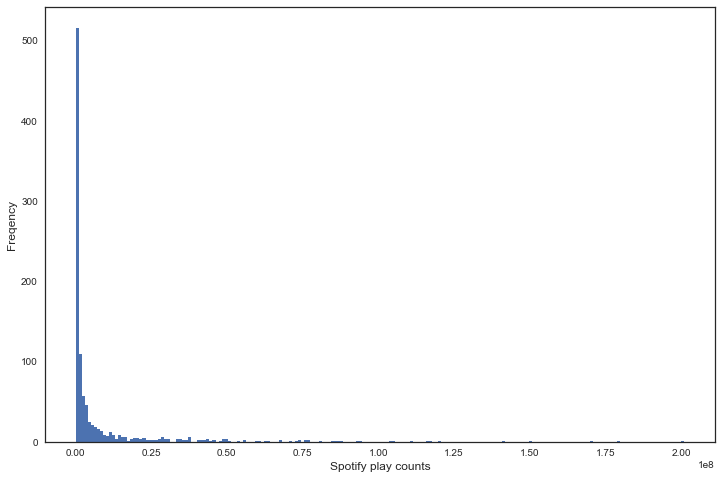

In [70]:
ax = df_playCount.plot.hist(bins=200, figsize=(12,8))
ax.set_xlabel("Spotify play counts", fontsize=12)
ax.set_ylabel("Freqency", fontsize=12)

In [71]:
df_playCount2 = df_music[df_music.SpotifyPlayCount < 1000000]

In [72]:
df_playCount2.shape

(513, 5)

The play count distribution is largely **skewed**. The biggest play count is over 200 million, while 513 out of 1000 songs have a play count lower than 1 million.

## 1.3 Histogram: Play Count (Logarithm)

In [73]:
df_playCount3 = np.log(df_music.SpotifyPlayCount)

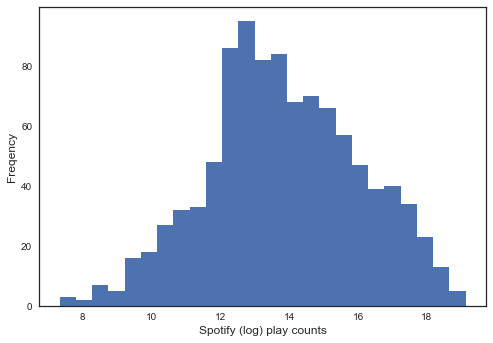

In [74]:
ax = df_playCount3.plot.hist(bins=25)
ax.set_xlabel("Spotify (log) play counts", fontsize=12)
ax.set_ylabel("Freqency", fontsize=12)

After logarithm, the distribution looks much like **bell shape**. It makes sense to change our original target to the log-target.

## 1.4 Heat Map: Correlation with Log Target

The following correlation heat map with **log** target is **better** than the correlation heat map with **original** target. A higher correlation implys that we are more likely to build a model with lower error.

In [75]:
df_music_clean = df_music.copy()
df_music_clean.SpotifyPlayCount = np.log(df_music_clean.SpotifyPlayCount)
df_music_clean.rename(columns={'SpotifyPlayCount':'LogPlayCount'}, inplace=True)

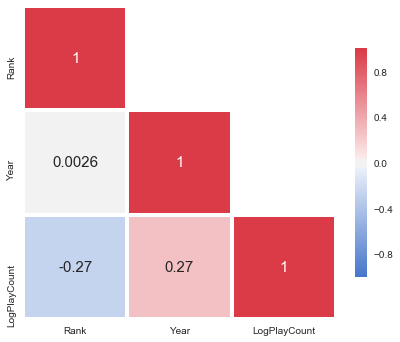

In [76]:
sns.set(style="white")
corr = df_music_clean.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})

## 1.5 Bar: Artists

In [77]:
ser_artists = df_music_clean.Artist

In [78]:
arr_artists = ser_artists.unique()

In [79]:
arr_artists.shape

(551,)

In [64]:
arr_artists.sort()

In [65]:
for i in arr_artists:
    print(i)

1910 Fruitgum Company
? and the Mysterians
Aaron Neville
Ace Cannon
Acker Bilk
Adam Wade
Al Hirt
Al Martino
Allan Sherman
Andy Kim
Andy Williams
Anita Bryant
Annette Funicello
Archie Bell and The Drells
Aretha Franklin
Arthur Conley
Arthur Lyman
B. J. Thomas
Barbara George
Barbara Lewis
Barbara Lynn
Barbara Mason
Barbra Streisand
Barrett Strong
Barry Mann
Barry McGuire
Ben E. King
Bent Fabric
Bert Kaempfert
Betty Everett
Betty Everett and Jerry Butler
Big Brother and The Holding Company
Bill Anderson
Bill Black's Combo
Bill Cosby
Bill Pursell
Billy Bland
Billy J. Kramer?and?The Dakotas
Billy Joe Royal
Billy Joe and The Checkmates
Billy Vaughn
Blood, Sweat and Tears
Blue Cheer
Blue Magoos
Bob Dylan
Bob Lind
Bob Luman
Bob Moore
Bob Seger System
Bobby Bare
Bobby Darin
Bobby Freeman
Bobby Fuller Four
Bobby Gentry
Bobby Goldsboro
Bobby Hebb
Bobby Lewis
Bobby Rydell
Bobby Sherman
Bobby Vee
Bobby Vee and The Strangers
Bobby Vinton
Booker T. and The M.G.'s
Brenda Lee
Brenton Wood
Brian Hyland


# 2 Baseline Model

## 2.1 Z-score the Features

In [8]:
def z_score_norm(df, feature_list):
    """ Dot the z-score method on selected features in feature_list. 
        z = (x - mean)/std
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())

In [24]:
z_score_norm(df_music_clean, feature_list=['Rank', 'Year'])

In [25]:
df_music_clean.head()

,Rank,Artist,Title,Year,LogPlayCount
0,-1.713078,Percy Faith,"Theme From ""A Summer Place""",-1.565505,15.425179
1,-1.678503,Jim Reeves,He'll Have To Go,-1.565505,15.291952
2,-1.643928,Everly Brothers,Cathy's Clown,-1.565505,15.246003
3,-1.609353,Johnny Preston,Running Bear,-1.565505,14.183606
4,-1.574778,Mark Dinning,Teen Angel,-1.565505,12.986026


## 2.2 Do the Linear Regression

Extract target and features

In [27]:
target = df_music_clean.loc[:,'LogPlayCount']
feature = df_music_clean.loc[:,['Rank', 'Year']]

In [31]:
feature.shape

(1000, 2)

# 3 Evaluation